# Classifying Leaf Using Basic Classifiers and FFNN  
  
  This project is aimed to build some classifiers to judge the type of leaves. Using three sets of features: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample. We will use some basic classifiers first and compare their performance about this dataset, and then using principal component analysis (PCA) to deduct the features and do the same process again and compare the difference bwtween this two situatiom. At last, we will develop an Feed Forward Neural Network to judge the type.  
  
  The result shows that NuSVC classifier has the best perfermance in all classifiers. After PCA process, most of classifier's perfermance is lower than before but the accuracy of Gaussian Naive Bayes model has doubled. Our FFNN network also has excellent perfermance for this dataset.

## Part A Basic Classifiers:

We can now start setting up our classifiers and naively apply them to the dataset as it is. Ideally, one should first look at the data in depth and think how to reduce it or manipulate it to get the most out of the classifiers. However, we will need these results later, to compare how effective the Features Reduction is in each case. To compare performance and efficacy of each technique we will use a K-fold cross validation. This technique randomly splits the training dataset in k subsets. While one subset is kept to test the model, the remaining k-1 sets are used to train the data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,GridSearchCV

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit


In [2]:
train = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv") I won't use test dataset in this project

In [3]:
# Swiss army knife function to organize the data
    
x_train = train.drop(['id', 'species'], axis=1)
y_train = train.pop('species')
#test = test.drop(['id'], axis=1)

#standardize the training values
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)



In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=4)

In [5]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)



classifiers = [
    KNeighborsClassifier(3),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


for clf in classifiers:
    clf_validation = [clf.fit(x_train[train], y_train[train]).score(x_train[test], y_train[test]).mean() \
           for train, test in kfold.split(x_train)]
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    acc = np.mean(clf_validation)
    print("Accuracy: {:.4%}".format(acc))
    
    
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 96.2626%
GaussianNB
****Results****
Accuracy: 48.6869%
DecisionTreeClassifier
****Results****
Accuracy: 59.5960%
RandomForestClassifier
****Results****
Accuracy: 85.3535%
AdaBoostClassifier
****Results****
Accuracy: 2.4242%
GradientBoostingClassifier
****Results****
Accuracy: 55.0505%
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.1717%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 2.9293%


The results are very interesting:
1. KNN: Since in our dataset, the number of samples for each type of leaves is the same, KNN has a good perfermance.  

2. GaussianNB: Naïve Bayes validation result is extremely low. This could be due to the fact that the initial assumption of independent features doesn't hold of this dataset.  
3. DecisionTreeClassifier & RandomForestClassifier: RF perfermance better than DecisionTree. Since we have no hyperparameter tuning here, accuracy is not good enough.
5. LDA & QDA:LDA only performs well if the decision boundary between classes is in fact linear, as all classes share a common covariance matrix.QDA is trying to create a quadratic boundary for 99 different classes, computing a unique covariance matrix for each class. With ~15 or fewer training samples for each class, I believe QDA is producing inaccurate covariance matrices and wildly unrealistic opinions about decision boundary, hence the massive log loss score.
  
  
It would be worth at this point to polish a bit the features, and see if by reducing their number we can improve the results of our classifiers.


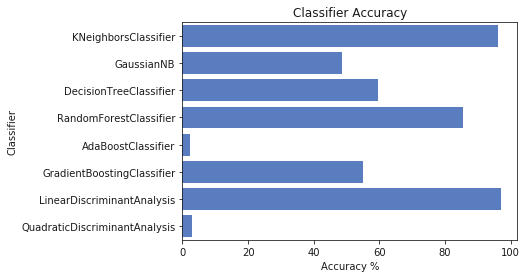

In [6]:

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()


The sklearn implementation of Random Forest allows to get information on which features are the most important in the classification; although not that useful here, it can usually be beneficial in the features reduction phase, to identify which descriptor are more likely to lead to loss of valuable information if dropped.

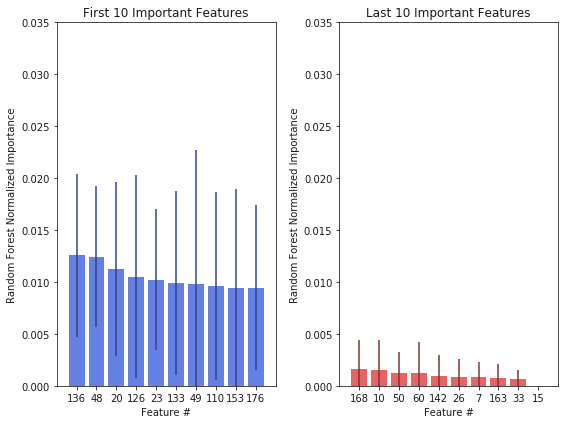

In [7]:
#We extract the importances, their indices and standard deviations
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

rf = RandomForestClassifier()
#Run K-fold validation with RF
#Again the classifier is trained on the k-1 sub-sets and then tested on the remaining k-th subset
#and scores are calcualted
rf_validation=[rf.fit(x_train[train], y_train[train]).score(x_train[test], y_train[test]).mean() \
               for train, test in kfold.split(x_train)]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
imp_std = np.std([est.feature_importances_ for est in rf.estimators_], axis=0)

#And we plot the first and last 10 features out of curiosity
fig = plt.figure(figsize=(8, 6))
gs1 = gridspec.GridSpec(1, 2)#, height_ratios=[1, 1]) 
ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax1.margins(0.05), ax2.margins(0.05) 
ax1.bar(range(10), importances[indices][:10], \
       color="#6480e5", yerr=imp_std[indices][:10], ecolor='#31427e', align="center")
ax2.bar(range(10), importances[indices][-10:], \
       color="#e56464", yerr=imp_std[indices][-10:], ecolor='#7e3131', align="center")
ax1.set_xticks(range(10)), ax2.set_xticks(range(10))
ax1.set_xticklabels(indices[:10]), ax2.set_xticklabels(indices[-10:])
ax1.set_xlim([-1, 10]), ax2.set_xlim([-1, 10])
ax1.set_ylim([0, 0.035]), ax2.set_ylim([0, 0.035])
ax1.set_xlabel('Feature #'), ax2.set_xlabel('Feature #')
ax1.set_ylabel('Random Forest Normalized Importance') 
ax2.set_ylabel('Random Forest Normalized Importance')
ax1.set_title('First 10 Important Features'), ax2.set_title('Last 10 Important Features')
gs1.tight_layout(fig)
plt.show()

A straightforward way to simplify the features is to remove possible correlations. We can intuitively assume that Naïve Bayes results will improve significantly, but it would be good to see if this choice will also improve the validation results for the other two classifiers.

The dataset contains total of 192 descriptors, subdivided in three categories: margin, shape and texture. We can first check if within each one of these categories the features are correlated by calculating correlation scores between couples of features (in this case we will use the Pearson's correlation coefficient), and then if one of the categories has highly correlated results, we can build a correlation matrix among all the descriptors within such category.

Pearson's Correlation between neighbours
Margin: 0.015 ± 0.311
Shape: 0.989 ± 0.003
Texture: -0.035 ± 0.184


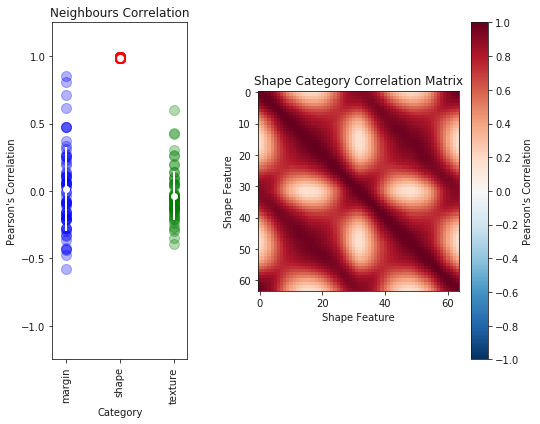

In [8]:
def pearson(x,y):
		sumxy = 0
		for i in range(len(x)):
			sumxy = sumxy + x[i]*y[i]
		return (sumxy - len(x)*np.mean(x)*np.mean(y))\
			/((len(x)-1)*np.std(x, ddof=1)*np.std(y, ddof=1))
    
    
#First we find the sets of margin, shape and texture columns 
margin_cols = [col for col in train.columns if 'margin' in col]
shape_cols = [col for col in train.columns if 'shape' in col] 
texture_cols = [col for col in train.columns if 'texture' in col] 
margin_pear, shape_pear, texture_pear = [],[],[]

#Then we calculate the correlation coefficients for each couple of columns: we can either do this
#between random columns of between consecutive columns, the difference won't matter much since we are
#just exploring the data
for i in range(len(margin_cols)-1):
    margin_pear.append(pearson(train[margin_cols[i]],train[margin_cols[i+1]]))
	#margin_pear.append(pearson(traindf[margin_cols[randint(0,len(margin_cols)-1)]],\
        #traindf[margin_cols[randint(0,len(margin_cols)-1)]]))
for i in range(len(shape_cols)-1):
	shape_pear.append(pearson(train[shape_cols[i]],train[shape_cols[i+1]]))
	#shape_pear.append(pearson(traindf[shape_cols[randint(0,len(shape_cols)-1)]],\
        #traindf[shape_cols[randint(0,len(shape_cols)-1)]]))
for i in range(len(texture_cols)-1):
	texture_pear.append(pearson(train[texture_cols[i]],train[texture_cols[i+1]]))
	#texture_pear.append(pearson(traindf[texture_cols[randint(0,len(texture_cols)-1)]],\
        #traindf[texture_cols[randint(0,len(texture_cols)-1)]]))

#We calculate average and standard deviation for each cathergory 
#and we give it a position on the X axis of the graph
margin_mean, margin_std = np.mean(margin_pear), np.std(margin_pear, ddof=1)
margin_x=[0]*len(margin_pear)
shape_mean, shape_std =	np.mean(shape_pear), np.std(shape_pear, ddof=1)
shape_x=[1]*len(shape_pear)	
texture_mean, texture_std =	np.mean(texture_pear), np.std(texture_pear, ddof=1)	
texture_x=[2]*len(texture_pear)

#We set up the graph
fig = plt.figure(figsize=(8, 6))
gs1 = gridspec.GridSpec(1, 2)#, height_ratios=[1, 1]) 
ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax1.margins(0.05), ax2.margins(0.05) 

#We fill the first graph with a scatter plot on a single axis for each category and we add
#mean and standard deviation, which we can also print to screen as a reference
ax1.scatter(margin_x, margin_pear, color='blue', alpha=.3, s=100)
ax1.errorbar([0],margin_mean, yerr=margin_std, color='white', alpha=1, fmt='o', mec='white', lw=2)
ax1.scatter(shape_x, shape_pear, color='red', alpha=.3, s=100)
ax1.errorbar([1],shape_mean, yerr=shape_std, color='white', alpha=1, fmt='o', mec='white', lw=2)
ax1.scatter(texture_x, texture_pear, color='green', alpha=.3, s=100)
ax1.errorbar([2],texture_mean, yerr=texture_std, color='white', alpha=1, fmt='o', mec='white', lw=2)
ax1.set_ylim(-1.25, 1.25), ax1.set_xlim(-0.25, 2.25)
ax1.set_xticks([0,1,2]), ax1.set_xticklabels(['margin','shape','texture'], rotation='vertical')
ax1.set_xlabel('Category'), ax1.set_ylabel('Pearson\'s Correlation')
ax1.set_title('Neighbours Correlation')
ax1.set_aspect(2.5)

print("Pearson's Correlation between neighbours\n==========================================")
print("Margin: " + '{:1.3f}'.format(margin_mean) + u' \u00B1 ' \
       + '{:1.3f}'.format(margin_std))
print("Shape: " + '{:1.3f}'.format(shape_mean) + u' \u00B1 ' \
       + '{:1.3f}'.format(shape_std))
print("Texture: " + '{:1.3f}'.format(texture_mean) + u' \u00B1 ' \
       + '{:1.3f}'.format(texture_std))

#And now, we build a more detailed (and expensive!) correlation matrix, 
#but only for the shape category, which, as we will see, is highly correlated
shape_mat=[]

for i in range(train[shape_cols].shape[1]):
    shape_mat.append([])
    for j in range(train[shape_cols].shape[1]):
        shape_mat[i].append(pearson(train[shape_cols[i]],train[shape_cols[j]]))

cmap = cm.RdBu_r
MS= ax2.imshow(shape_mat, interpolation='none', cmap=cmap, vmin=-1, vmax=1)
ax2.set_xlabel('Shape Feature'), ax2.set_ylabel('Shape Feature')
cbar = plt.colorbar(MS, ticks=np.arange(-1.0,1.1,0.2))
cbar.set_label('Pearson\'s Correlation')
ax2.set_title('Shape Category Correlation Matrix')

#And we have a look at the resulting graphs
gs1.tight_layout(fig)
plt.show()

The Pearson's Coefficient goes from 1 for perfectly correlated arrays, to -1 for perfectly anti-correlated arrays. The midpoint 0 represents uncorrelated data. The results shown in the graph are very interesting. From the plot on the left it's possible to observe that couples of features categorised under "texture" (in green) are fairly uncorrelated, the mean is close to zero and the variance is low, with only one case with correlation higher then 0.5. Similarly, the "margin" features are centred in zero, but their variance is higher and we can observe a few points with about 0.8 of correlation.

The most striking result is however observed with the "shape" category, where close couples of features are highly correlated. Taking random couples of descriptors doesn't improve the situation much, and this can be easily understood by looking in detail at the second graph, where the correlation matrix of all the features is shown. The descriptors are highly correlated with their closest neighbours, but also with other features periodically. This data forms a nice pattern, yes, but can lead to bad results if not properly taken care of. This also confirms our theory that the starting assumption of Naïve Bayes was wrong.

Obviously correlation is not the only parameter one should look at when cleaning the data, but for this notebook we are going to focus only on this problem.

## Part B Principal Component Analysis & Compare the Perfermance Difference
### Principal Component Analysis  
Principal Component Analysis (or PCA in short) allows to transform sets of correlated variables, like our leaves features, into linearly uncorrelated, orthogonal, vectors (the principal components). The output sets are ordered so that the first principal component accounts for as much variability (and thus information) as possible from the input data, and it has the largest variance, while the following vectors have the highest possible variance allowed by their orthogonality.

The number of sets in output can be lower than the number of input features, sometimes all information from our descriptors can be contained in a lower number of vectors, and for this reason PCA is often used as a dimensionality reduction method. It implementation in sklearn is based on the Singular Value Decomposition (or SVD), a method to extract the eigenvectors, the orthogonal vectors, by means of a factorisation of the matrix of the input features.

Although in principle we could apply PCA it only to a subset of the training data, given that some of the categories don't have much correlation among their members, we will apply here to the whole data set, to make sure that all features are orthogonal.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100, svd_solver = 'full')
#Then we fit pca on our training set and we apply to the same entire set
x_train_pca=pca.fit_transform(x_train)
print("Number of descriptors before PCA: " + '{:1.0f}'.format(x_train.shape[1]))
print("Number of descriptors after PCA: " + '{:1.0f}'.format(x_train_pca.shape[1]))


Number of descriptors before PCA: 192
Number of descriptors after PCA: 100


In [10]:
pca.explained_variance_ratio_
sum =0
for int in pca.explained_variance_ratio_:
    sum = sum +int
    
print (sum)

0.9813056160162076


As we can see, PCA only reduced the features by one element. This doesn't mean, however, that the results won't be improved. We can now apply again our classifiers to this new set and see if anything has changed.  

And also, The percentage of variance for all features is 0.9813056160162076, meaning that almost all information is retained.

In [11]:
for clf in classifiers:
    clf_validation = [clf.fit(x_train_pca[train], y_train[train]).score(x_train_pca[test], y_train[test]).mean() \
           for train, test in kfold.split(x_train)]
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    acc = np.mean(clf_validation)
    print("Accuracy: {:.4%}".format(acc))
    
    
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 96.2626%
GaussianNB
****Results****
Accuracy: 93.3333%
DecisionTreeClassifier
****Results****
Accuracy: 59.8990%
RandomForestClassifier
****Results****
Accuracy: 76.0606%
AdaBoostClassifier
****Results****
Accuracy: 2.7273%
GradientBoostingClassifier
****Results****
Accuracy: 44.3434%
LinearDiscriminantAnalysis
****Results****
Accuracy: 98.0808%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 5.8586%


As we expected, most of the classifiers' accuracy is lower compared with the first dataset since some information lost in this dimensionality reduction process, but the validation results improve significantly for the Naïve Bayes classifier, since now the features independence assumption is correct.

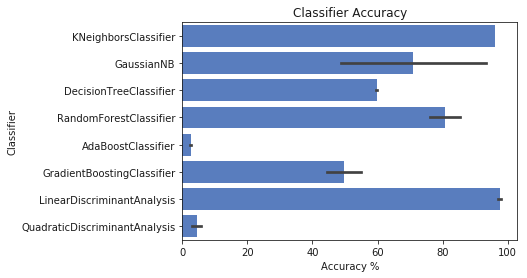

In [12]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()


In [13]:
df = pd.read_csv("train.csv")
pca = PCA(n_components=3)

# Obtain list of features
features = list(df)
del(features[:2]) # Delete id and species from features

# Apply PCA to our data
pca_result = pca.fit_transform(df[features].values)

# Define dataframe containing low-dimension representation of original data
pca_df = pd.DataFrame()
pca_df['species'] = df['species']
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 

# How much variance does this new representation retain from the original data?
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14980004 0.101889   0.08671815]


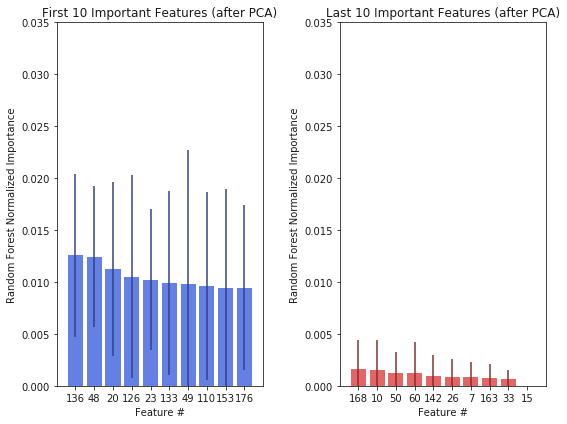

In [14]:
#Again, we can check if anything changed in the features importance of our Random Forest classifier
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
imp_std = np.std([est.feature_importances_ for est in rf.estimators_], axis=0)

fig = plt.figure(figsize=(8, 6))
gs1 = gridspec.GridSpec(1, 2)#, height_ratios=[1, 1]) 
ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax1.margins(0.05), ax2.margins(0.05) 
ax1.bar(range(10), importances[indices][:10], \
       color="#6480e5", yerr=imp_std[indices][:10], ecolor='#31427e', align="center")
ax2.bar(range(10), importances[indices][-10:], \
       color="#e56464", yerr=imp_std[indices][-10:], ecolor='#7e3131', align="center")
ax1.set_xticks(range(10)), ax2.set_xticks(range(10))
ax1.set_xticklabels(indices[:10]) ,ax2.set_xticklabels(indices[-10:])
ax1.set_xlim([-1, 10]), ax2.set_xlim([-1, 10])
ax1.set_ylim([0, 0.035]), ax2.set_ylim([0, 0.035])
ax1.set_xlabel('Feature #'), ax2.set_xlabel('Feature #')
ax1.set_ylabel('Random Forest Normalized Importance'), ax2.set_ylabel('Random Forest Normalized Importance')
ax1.set_title('First 10 Important Features (after PCA)'), ax2.set_title('Last 10 Important Features (after PCA)')
gs1.tight_layout(fig)
#plt.show()

However, looking at the feature importances of the Random Forest classifier we can see how the information has been restructured and divided among the features. The 10 first important features (on the left) are taken among the first in the first vectors of the PCA, the ones with highest variance, while the least important features for the classifier are mostly among the last vectors of our modified dataset, where the remaining information has been stored. Dropping them would lead to a modest loss of information. Moreover, the actual value of the importance is increased for the first ten vectors and equally low for the last ten.
It is interesting to note how this rearrangement of the information through PCA and the elimination of just one descriptor doesn't significantly affect the results for the Random Forest classifier.

## Part C Feed Forward Neural Network

Now, let us proceed by applying Feed Forward Neural Network to this dataset. A Feed Forward Neural Network is a Neural Network that is built by layers. Each layer consists of a set of neurons. Particularity of these networks is that units within the same layer do not interact between each other. The following figure illustrates the architecture of these networks:  
![FFNN](ffnn.png)  
The input layer is where we introduce the training data. In this first attempt, we will use the feature vectors. Thus, the input layer has 192 units. In Classification problems, the output layer has as many units as classes we have in our problem (in our case, we have 99). In between, we have the hidden layers (the number of hidden layers might vary from task to task).

In general, at each layer these networks compute linear combinations of the output vector of the previous layer and subsequently apply non-linearities (also known as activation functions). In our case, we will be using the ReLu activation function, which has been proven in the literature to be robust to the vanishing gradient problem and has a faster convergence than other standard activation functions (e.g. sigmoid, tanh).



### Preparing the data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf

# Parameters
learning_rate = 0.001
training_epochs = 2000
batch_size = 10
display_step = 100

# Network Parameters
n_features = 192
n_classes = 99
neurons_layers = [n_features, 256, n_classes] # Number of features in input, hidden and output layers

# Load Train data
train_data = {}
df = pd.read_csv("train.csv") # Load training set
tmp = df.as_matrix()
train_data['samples'] = tmp[:, 2:] # Obtain all the feature vectors (without ids and species)
train_data['labels'] = tmp[:, 1] # Obtain labels (i.e. species)
N_train = len(train_data['samples']) # Number of training samples

# Obtain list of features
features = list(df)
del(features[:2]) # Delete id and species from features

# Load Test data
test_data = {}
df = pd.read_csv("test.csv")
tmp = df.as_matrix()
test_data['samples'] = tmp[:, 1:]
test_ids = df.pop('id')

/Users/linke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/linke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/linke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### One-Hot Encoding

In [2]:
# One hot encoding map something
enc = np.eye(n_classes)
sparse2dense = {i: enc[i] for i in range(n_classes)}

# Map class names to one-hot representation
class_names = np.unique(train_data['labels'])
class_encodings = {}
for i in range(n_classes):
    class_encodings[class_names[i]] = sparse2dense[i]

### Model parameters initialisation

In [3]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_features])
y = tf.placeholder(tf.float32, [None, n_classes])

# Model parameters (weights, biases)
weights = [
    tf.Variable(tf.random_normal([neurons_layers[k], neurons_layers[k + 1]])) for k in range(len(neurons_layers)-1)
]

biases = [
    tf.Variable(tf.random_normal([neurons_layers[k+1]])) for k in range(len(neurons_layers)-1)
]

### Multilayer Perceptron

In [4]:
# Function implementing a fully connected feed forward NN, with relu activations
def multilayer_perceptron(x, weights, biases):
    
    # Compute number of hidden layers
    n_hidden = len(weights)-1
    
    # Input layer to hidden layer
    out = tf.add(tf.matmul(x, weights[0]), biases[0])
    
    # Check that there are hidden layers
    if n_hidden > 0:
    
        # Iterate over all hidden layers
        for k in range(1, n_hidden+1):
            out = tf.nn.relu(out) # Apply activation fct on previous layer output
            out = tf.add(tf.matmul(out, weights[k]), biases[k]) # linear combination
               
    return out


### Cost and Optimiser

In [5]:
# Construct model
y_pred = multilayer_perceptron(x, weights, biases)
p_pred = tf.nn.softmax(y_pred)

# Define cross entropy loss
cost = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y)
cost = tf.reduce_mean(cost)*batch_size

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluation of the model on a set
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Building our first model

In [6]:
# Create Validation and Training sets
tmp = pd.read_csv("train.csv").as_matrix()

idx = np.random.choice(N_train, N_train, replace=False)
N_train2 = int (0.75 * N_train)
train_data['samples'] = tmp[idx[:N_train2], 2:]
train_data['labels'] = np.array([class_encodings[t] for t in tmp[idx[:N_train2], 1]])

val_data = {}
val_data['samples'] = tmp[idx[N_train2:], 2:]
val_data['labels'] = np.array([class_encodings[t] for t in tmp[idx[N_train2:], 1]])

/Users/linke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Check the accurancy

In [ ]:
# Arrays containing cost for each epoch
cost_train_original = np.zeros([training_epochs,1])
cost_val_original = np.zeros([training_epochs,1])
accuracy_original = np.zeros([training_epochs,1])
# Initializing the variables
init = tf.global_variables_initializer()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(N_train2/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            idx = range(i*batch_size, (i+1)*batch_size)
            # Train samples
            batch_x = train_data['samples'][idx]
            # Train labels
            #print(idx)
            batch_y = train_data['labels'][idx]

            ## Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
            print("Accuracy on Validation nset:", accuracy.eval({x: val_data['samples']\
                                                                , y: val_data['labels']}))
        cost_train_original[epoch] = avg_cost
        cost_val_original[epoch] = cost.eval({x: val_data['samples'], y: val_data['labels']})
        accuracy_original[epoch] = accuracy.eval({x: val_data['samples'], y: val_data['labels']})
        
    print("Optimization Finished!")

    
    
    predictions = sess.run([p_pred], {x: test_data['samples']})

Epoch: 0001 cost= 236.245000891
Accuracy on Validation nset: 0.016129032
Epoch: 0101 cost= 0.075863953
Accuracy on Validation nset: 0.8951613
Epoch: 0201 cost= 0.001859059
Accuracy on Validation nset: 0.9354839
Epoch: 0301 cost= 0.000048346
Accuracy on Validation nset: 0.9395161
Epoch: 0401 cost= 0.000001252
Accuracy on Validation nset: 0.94758064
Epoch: 0501 cost= 0.000000285
Accuracy on Validation nset: 0.94758064
Epoch: 0601 cost= 0.000003805
Accuracy on Validation nset: 0.94758064
Epoch: 0701 cost= 0.000000182
Accuracy on Validation nset: 0.95564514
Epoch: 0801 cost= 0.084191272
Accuracy on Validation nset: 0.9032258
Epoch: 0901 cost= 0.000000456
Accuracy on Validation nset: 0.9354839
Epoch: 1001 cost= 0.000000163
Accuracy on Validation nset: 0.9516129


As the result shows, our netwrok become plateaus between 500 and 600 epochs. The accuracy rate is also maintained at around 0.947.